## **Intorduction**

Summary

## **Libraries**

In [1]:
#%pip install geopandas
#%pip install spreg
#%pip install statsmodels

In [1]:
# Import required libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import spreg
from libpysal.weights import Queen
from statsmodels.stats.outliers_influence import variance_inflation_factor

## **Loading Data**

In [2]:
LV_metro_gdf =gpd.read_file('LV_metro_final.shp')

print(LV_metro_gdf.shape)
LV_metro_gdf.columns

(510, 16)


Index(['GEOID', 'funding_pe', 'pre1940_pc', 'overcrowd_', 'new_units_',
       'bachelor_p', 'unemployed', 'asian_pct', 'black_pct', 'hispanic_p',
       'owner_occu', 'vacant_pct', 'BPL_child_', 'value_chan', 'HAI_change',
       'geometry'],
      dtype='object')

In [ ]:
#Run as needed
#LV_metro_gdf.to_csv('LV_metro_final.csv')

## **Multicollinearity Test**


Multicollinearity Test:
     Predictor   VIF  Tolerance
9   owner_occu  8.41       0.12
4   bachelor_p  8.18       0.12
8   hispanic_p  4.74       0.21
5   unemployed  4.56       0.22
11  BPL_child_  4.19       0.24
6    asian_pct  3.09       0.32
7    black_pct  2.93       0.34
10  vacant_pct  2.63       0.38
2   overcrowd_  2.22       0.45
3   new_units_  1.52       0.66
12  value_chan  1.45       0.69
0   funding_pe  1.10       0.91
1   pre1940_pc  1.07       0.93


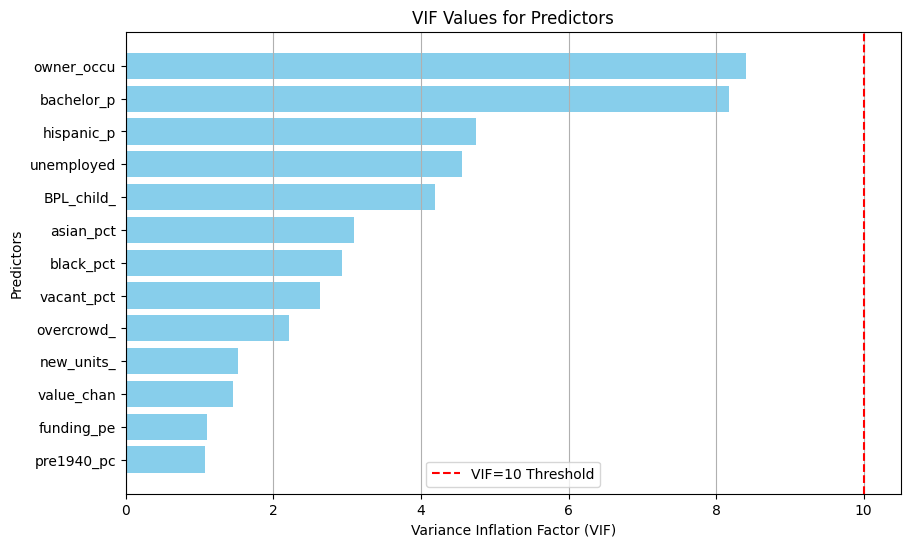

In [3]:
# Select the features for multicollinearity check
multicol_df = LV_metro_gdf[[
    'funding_pe', 'pre1940_pc', 'overcrowd_', 'new_units_', 
    'bachelor_p', 'unemployed', 'asian_pct', 'black_pct',  
    'hispanic_p', 'owner_occu', 'vacant_pct', 'BPL_child_', 'value_chan'
    ]]

# Drop rows with any missing values (or use a different strategy as needed)
multicol_df_filtered = multicol_df.dropna()

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Predictor"] = multicol_df_filtered.columns
vif["VIF"] = [variance_inflation_factor(multicol_df_filtered.values, i) for i in range(multicol_df_filtered.shape[1])]
vif["Tolerance"] = [1 / vif_val if vif_val != 0 else float('inf') for vif_val in vif["VIF"]]  # Avoid divide by zero errors

# Display results
print('\n\033[1m' + 'Multicollinearity Test:' + '\n\033[0m' + str(vif.sort_values('VIF', ascending=False).round(2)))

# Sort VIF values in descending order for visualization
vif_sorted = vif.sort_values('VIF', ascending=False)

# Visualization of VIF values
plt.figure(figsize=(10, 6))
plt.barh(vif_sorted['Predictor'], vif_sorted['VIF'], color='skyblue')
plt.xlabel('Variance Inflation Factor (VIF)')
plt.ylabel('Predictors')
plt.title('VIF Values for Predictors')
plt.axvline(x=10, color='red', linestyle='--', label='VIF=10 Threshold')
plt.legend()
plt.gca().invert_yaxis()  # Invert y-axis to show highest VIFs at the top
plt.grid(axis='x')
plt.show()

## **Variables and Weight Matrix**

In [4]:
# Defining dependent and independent variables
y = LV_metro_gdf['HAI_change'].values

X = LV_metro_gdf[[
                'funding_pe',
                'pre1940_pc',
                'overcrowd_',
                'new_units_', 
                'bachelor_p',
                'unemployed',
                'asian_pct',
                'black_pct',  
                'hispanic_p',
                'owner_occu',
                'vacant_pct',
                'BPL_child_',
                'value_chan'   
                ]].values

# Setting up spatial weights matrix
w = Queen.from_dataframe(LV_metro_gdf, use_index=True)
w.transform = 'r'

## **1) OLS Model**

In [6]:
# Spatial Ordinary Least Square Model
model_OLS = spreg.OLS(y, X, w, robust='white', slx_lags=0, spat_diag=True, moran=True, white_test=False, vm=False, sig2n_k=True,
                      name_y='HAI_CHANGE',
                      name_x=[
                              'funding_per_capita', 'pre1940_pct', 'overcrowd_pct', 'new_units_pct', 
                              'bachelor_pct', 'unemployment_pct', 'asian_pct', 'black_pct', 'hispanic_pct', 
                              'owner_occupied_pct', 'vacant_pct', 'BPL_child_pct', 'value_change_pct'],
                       name_w='QUEEN', name_ds='LV-Henderson-Paradise, MSA')

# Display the model summary
print(model_OLS.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :LV-Henderson-Paradise, MSA
Weights matrix      :       QUEEN
Dependent Variable  :  HAI_CHANGE                Number of Observations:         510
Mean dependent var  :      0.1991                Number of Variables   :          14
S.D. dependent var  :      0.3795                Degrees of Freedom    :         496
R-squared           :      0.0919
Adjusted R-squared  :      0.0681
Sum squared residual:     66.5808                F-statistic           :      3.8629
Sigma-square        :       0.134                Prob(F-statistic)     :   5.683e-06
S.E. of regression  :       0.366                Log likelihood        :    -204.480
Sigma-square ML     :       0.131                Akaike info criterion :     436.960
S.E of regression ML:      0.3613                Schwarz criterion     :     496.242

White Standard Errors
------------------------

## **2) SAR Model**

In [7]:
# SAR model
model_SAR = spreg.ML_Lag(y, X, w=w, slx_lags=0, method = 'Full', name_y='HAI_CHANGE',
               name_x=[ 'funding_per_capita', 'pre1940_pct', 'overcrowd_pct', 'new_units_pct', 
                        'bachelor_pct', 'unemployment_pct', 'asian_pct', 'black_pct', 'hispanic_pct', 
                        'owner_occupied_pct', 'vacant_pct', 'BPL_child_pct', 'value_change_pct'], 
               name_w='QUEEN', name_ds='LV-Henderson-Paradise, MSA')

print(model_SAR.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :LV-Henderson-Paradise, MSA
Weights matrix      :       QUEEN
Dependent Variable  :  HAI_CHANGE                Number of Observations:         510
Mean dependent var  :      0.1991                Number of Variables   :          15
S.D. dependent var  :      0.3795                Degrees of Freedom    :         495
Pseudo R-squared    :      0.4331
Spatial Pseudo R-squared:  0.0774
Log likelihood      :   -114.1149
Sigma-square ML     :      0.0837                Akaike info criterion :     258.230
S.E of regression   :      0.2892                Schwarz criterion     :     321.746

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------------------------

## **3) SARMA Model**

In [8]:
# Fit the SARMA model with Heteroskedastic errors
model_SARMA_HET = spreg.GM_Combo_Het(y, X, w=w, slx_lags=0, lag_q=False, vm=False, # vm=True enables robust variance matrix
    name_y="HAI_CHANGE",
    name_x=['funding_per_capita', 'pre1940_pct', 'overcrowd_pct', 'new_units_pct', 
            'bachelor_pct', 'unemployment_pct', 'asian_pct', 'black_pct', 
            'hispanic_pct', 'owner_occupied_pct', 'vacant_pct', 'BPL_child_pct', 'value_change_pct'],
    name_w='QUEEN', name_ds='LV-Henderson-Paradise, MSA'
    )

# Output model summary
print(model_SARMA_HET.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIALLY WEIGHTED 2SLS- GM-COMBO MODEL (HET)
----------------------------------------------------------------
Data set            :LV-Henderson-Paradise, MSA
Weights matrix      :       QUEEN
Dependent Variable  :  HAI_CHANGE                Number of Observations:         510
Mean dependent var  :      0.1991                Number of Variables   :          15
S.D. dependent var  :      0.3795                Degrees of Freedom    :         495
Pseudo R-squared    :      0.4360
Spatial Pseudo R-squared:  0.0060
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -0.05103         0.08088        -0.63102         0.52803


## **4) Spatial Durbin Model**

In [9]:
# Spatial Durbin Model using ML_Lag (which is actually fitting a spatial lag model here)
model_SDM = spreg.ML_Lag(y, X, w, slx_lags=1, vm=False, 
               name_y='HAI_CHANGE', 
               name_x=[ 'funding_per_capita', 'pre1940_pct', 'overcrowd_pct', 'new_units_pct', 
                        'bachelor_pct', 'unemployment_pct', 'asian_pct', 'black_pct', 'hispanic_pct', 
                        'owner_occupied_pct', 'vacant_pct', 'BPL_child_pct', 'value_change_pct'], 
               name_w="QUEEN", name_ds='LV-Henderson-Paradise MSA')

# Print the results
print(model_SDM.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG WITH SLX - SPATIAL DURBIN MODEL (METHOD = FULL)
-------------------------------------------------------------------------------------------------
Data set            :LV-Henderson-Paradise MSA
Weights matrix      :       QUEEN
Dependent Variable  :  HAI_CHANGE                Number of Observations:         510
Mean dependent var  :      0.1991                Number of Variables   :          28
S.D. dependent var  :      0.3795                Degrees of Freedom    :         482
Pseudo R-squared    :      0.4493
Spatial Pseudo R-squared:  0.2288
Log likelihood      :   -100.6085
Sigma-square ML     :      0.0804                Akaike info criterion :     257.217
S.E of regression   :      0.2835                Schwarz criterion     :     375.781

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic   

## **Model comparison**

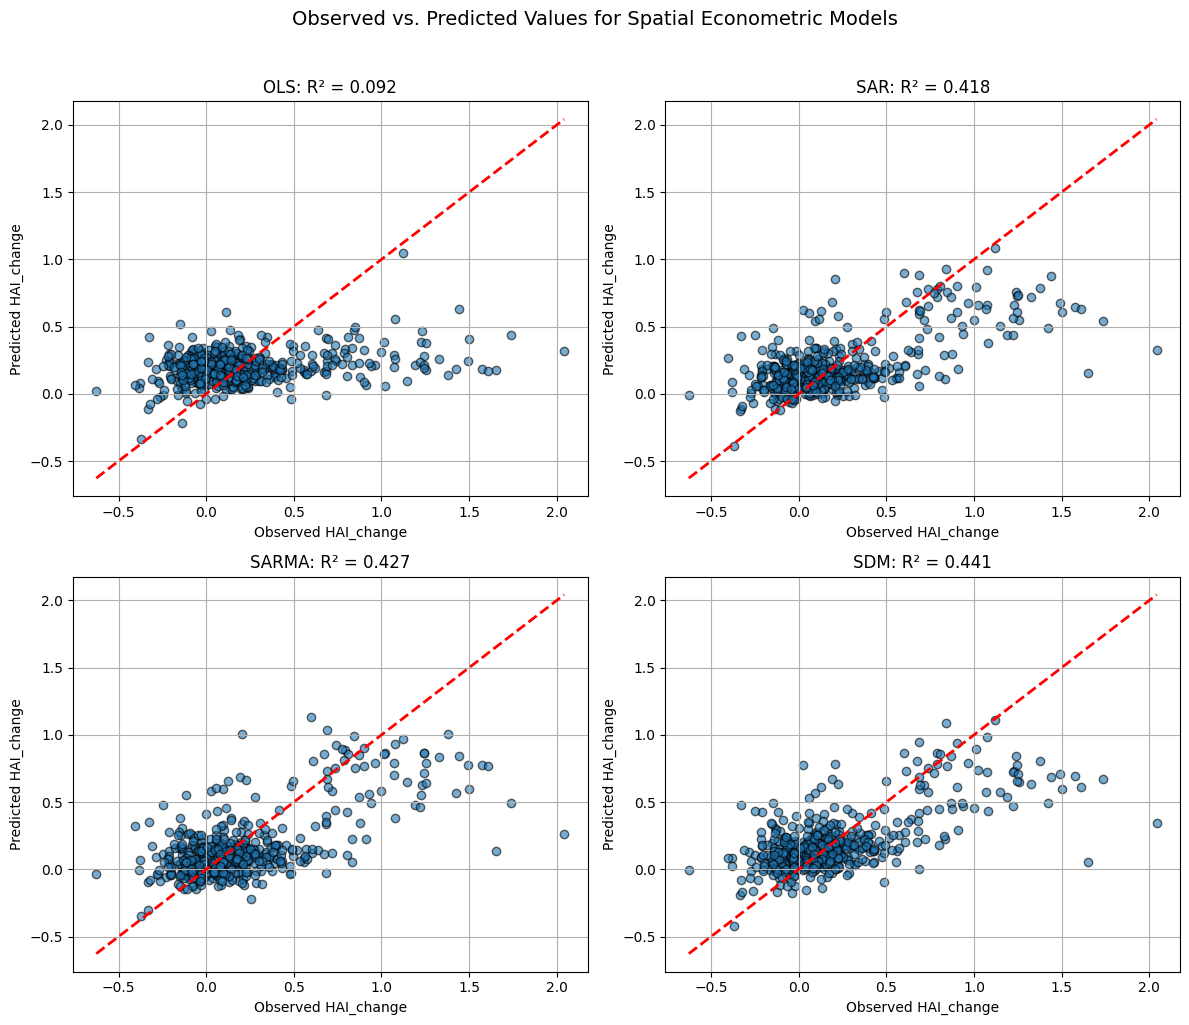

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Predicted values
y_pred_OLS = model_OLS.predy.flatten()
y_pred_SAR = model_SAR.predy.flatten()
y_pred_SARMA = model_SARMA_HET.predy.flatten()
y_pred_SDM = model_SDM.predy.flatten()

# Observed values
y_obs = y.flatten()

# Pseudo R² function
def pseudo_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

# R² values
r2_vals = [
    pseudo_r2(y_obs, y_pred_OLS),
    pseudo_r2(y_obs, y_pred_SAR),
    pseudo_r2(y_obs, y_pred_SARMA),
    pseudo_r2(y_obs, y_pred_SDM)
]
model_names = ['OLS', 'SAR', 'SARMA', 'SDM']
predictions = [y_pred_OLS, y_pred_SAR, y_pred_SARMA, y_pred_SDM]

# Set up subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.scatter(y_obs, predictions[i], alpha=0.6, edgecolor='k')
    ax.plot([y_obs.min(), y_obs.max()], [y_obs.min(), y_obs.max()], 'r--', lw=2)
    ax.set_title(f'{model_names[i]}: R² = {r2_vals[i]:.3f}')
    ax.set_xlabel('Observed HAI_change')
    ax.set_ylabel('Predicted HAI_change')
    ax.grid(True)

plt.suptitle('Observed vs. Predicted Values for Spatial Econometric Models', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()